2025-06-13 13:33:50,911 - INFO - Début du pipeline supervisé de détection des outliers.
2025-06-13 13:33:55,314 - INFO - 267468 utilisateurs chargés depuis MongoDB.
2025-06-13 13:33:55,340 - INFO - 12298 profils détectés comme atypiques.



--- Rapport de classification ---
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     76552
           1     0.9997    1.0000    0.9999      3689

    accuracy                         1.0000     80241
   macro avg     0.9999    1.0000    0.9999     80241
weighted avg     1.0000    1.0000    1.0000     80241


--- Matrice de confusion ---
[[76551     1]
 [    0  3689]]


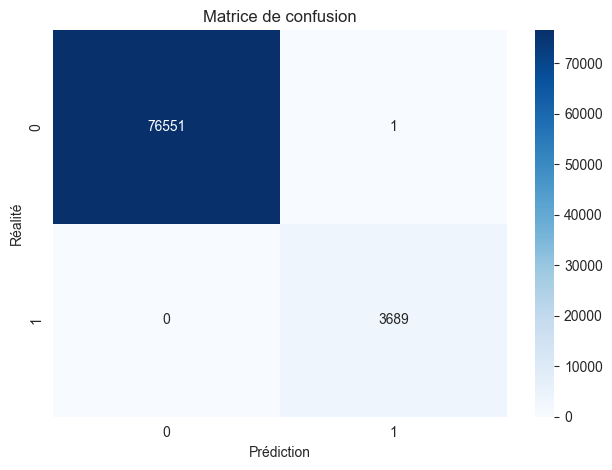

C:\Users\MSI\AppData\Local\Temp\ipykernel_2136\3028616063.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="coolwarm")


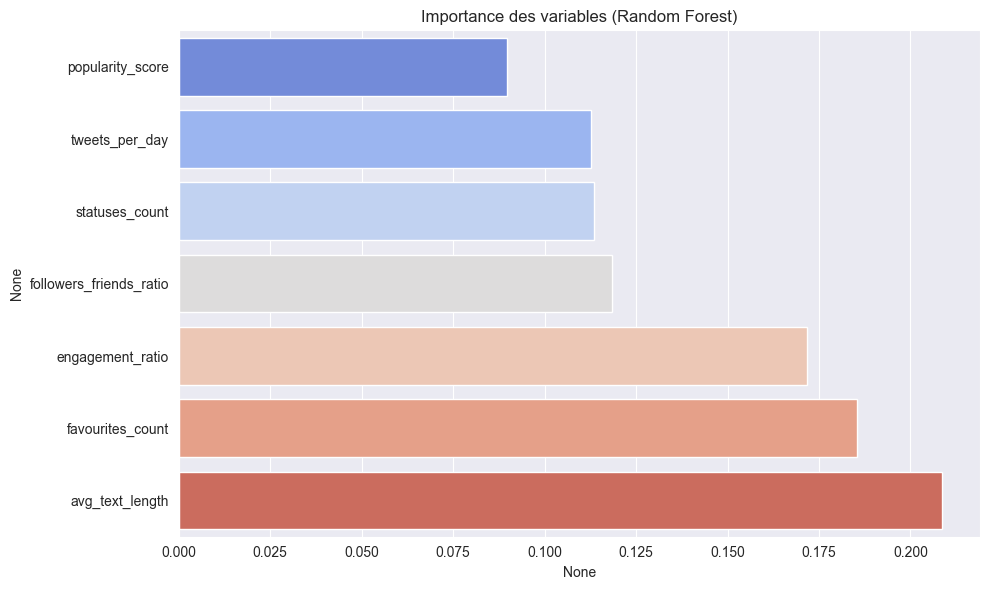

2025-06-13 13:34:36,445 - INFO - Données sauvegardées dans la nouvelle collection : 'users_labeled_outliers'
2025-06-13 13:34:36,446 - INFO - Pipeline supervisé terminé avec succès.


In [3]:
import os
import logging
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Étape 1 : Setup Logging & Directories ===
def setup_environment():
    for folder in ["logs", "images"]:
        os.makedirs(folder, exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.FileHandler(f"logs/supervised_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log", encoding="utf-8"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_environment()
logger.info("Début du pipeline supervisé de détection des outliers.")

# === Étape 2 : Connexion à MongoDB et chargement ===
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]
users_df = pd.DataFrame(list(db["user_db"].find()))

if users_df.empty:
    raise ValueError("La collection 'user_db' est vide.")

logger.info(f"{len(users_df)} utilisateurs chargés depuis MongoDB.")

# === Étape 3 : Calcul des percentiles ===
variables = [
    "favourites_count", "statuses_count", "tweets_per_day",
    "followers_friends_ratio", "engagement_ratio",
    "popularity_score", "avg_text_length"
]

thresholds = {var: users_df[var].quantile(0.99) for var in variables}

# === Étape 4 : Définition des outliers (1%) ===
users_df["is_outlier"] = (
    (users_df["favourites_count"] > thresholds["favourites_count"]) |
    (users_df["statuses_count"] > thresholds["statuses_count"]) |
    (users_df["tweets_per_day"] > thresholds["tweets_per_day"]) |
    (users_df["followers_friends_ratio"] > thresholds["followers_friends_ratio"]) |
    (users_df["engagement_ratio"] > thresholds["engagement_ratio"]) |
    (users_df["popularity_score"] > thresholds["popularity_score"]) |
    (users_df["avg_text_length"] > thresholds["avg_text_length"])
).astype(int)

nb_outliers = users_df["is_outlier"].sum()
logger.info(f"{nb_outliers} profils détectés comme atypiques.")

# === Étape 5 : Modèle supervisé ===
X = users_df[variables].fillna(0)
y = users_df["is_outlier"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# === Étape 6 : Rapport et visualisation ===
print("\n--- Rapport de classification ---")
print(classification_report(y_test, y_pred, digits=4))

print("\n--- Matrice de confusion ---")
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.tight_layout()
plt.savefig("images/confusion_matrix_supervised.png")
plt.show()

# === Étape 7 : Importance des variables ===
importances = pd.Series(model.feature_importances_, index=variables).sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette="coolwarm")
plt.title("Importance des variables (Random Forest)")
plt.tight_layout()
plt.savefig("images/feature_importance_supervised.png")
plt.show()

# === Étape 8 : Sauvegarde MongoDB ===
users_df["predicted_outlier"] = model.predict(X)
collection_name = f"users_labeled_outliers"
db[collection_name].insert_many(users_df.to_dict("records"))

logger.info(f"Données sauvegardées dans la nouvelle collection : '{collection_name}'")
logger.info("Pipeline supervisé terminé avec succès.")

# === Étape 9 : Fermeture propre ===
client.close()
